라이브러리 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 처리
import pandas as pd
import numpy as np

# 데이터 전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score

# 모델
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve


import matplotlib.pyplot as plt
import seaborn as sns

데이터 전처리

In [2]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# "UID" 컬럼 처리
test_uid = test_df[["UID"]]
train_df.drop(columns=["UID"], inplace=True)
test_df.drop(columns=["UID"], inplace=True)

# X, y 분리
X = train_df.drop(columns=["채무 불이행 여부"])
y = train_df["채무 불이행 여부"]

In [3]:
# 파생 변수 생성: "마지막 연체 이후 경과 개월 수"가 0이면 "연체 없음" 컬럼 추가
X["연체 없음"] = (X["마지막 연체 이후 경과 개월 수"] == 0).astype(int)
test_df["연체 없음"] = (test_df["마지막 연체 이후 경과 개월 수"] == 0).astype(int)

In [4]:
# 범주형 데이터 처리
loan_period_map = {"단기 상환": 0, "장기 상환": 1}
loan_purpose_map = {
    "교통비": 0, "여행 자금": 1, "교육비": 2, "이사 비용": 3,
    "결혼 자금": 4, "사업 대출": 5, "투자금": 6, "자동차 구매": 7,
    "기타": 8, "부채 통합": 9, "휴가 비용": 10, "주택 개보수": 11
}
job_tenure_map = {
    "5년": 0, "4년": 1, "2년": 2, "6년": 3, "9년": 4, "3년": 5, "8년": 6, "10년 이상": 7, "7년": 8, "1년 미만": 9
}
housing_type_map = {"주택임대(월세 포함)": 0, "자가": 1, "주택담보대출(가구 중)": 2, "월세": 3}

loan_period = "대출 상환 기간"
loan_purpose = "대출 목적"
job_tenure = "현재 직장 근속 연수"
housing_type = "주거 형태"

for df in [X, test_df]:
    df[loan_period] = df[loan_period].map(loan_period_map)
    df[loan_purpose] = df[loan_purpose].map(loan_purpose_map)
    df[job_tenure] = df[job_tenure].map(job_tenure_map)
    df[housing_type] = df[housing_type].map(housing_type_map)

In [5]:
# 함수 정의
# 원저라이징: 상/하한 범위로 자름.
def winsorize_series(s, lower_quantile=0.01, upper_quantile=0.99):
    lower_val = s.quantile(lower_quantile)
    upper_val = s.quantile(upper_quantile)
    return s.clip(lower_val, upper_val)

# IQR 기반 이상치 처리
def iqr_capping(df, col, factor=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + factor * IQR
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

In [6]:
# 함수적용 및 로그변환
log_columns = ["현재 미상환 신용액", "월 상환 부채액", "현재 대출 잔액"]
for df in [X, test_df]:
    for col in log_columns:
        df[col] = winsorize_series(df[col], 0.01, 0.99)
        df[col] = np.log1p(df[col])

for df in [X, test_df]:
    iqr_capping(df, "연간 소득", factor=1.5)

In [7]:
knn_imputer = KNNImputer(n_neighbors=10)
X_imputed = knn_imputer.fit_transform(X)
test_imputed = knn_imputer.transform(test_df)

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
test_scaled = scaler.transform(test_imputed)

모델링

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

sgd_model = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, random_state=42)
)

sgd_model.fit(X_train, y_train)
print("Train Score:", sgd_model.score(X_train, y_train))
print("Test Score :", sgd_model.score(X_test, y_test))

Train Score: 0.6965
Test Score : 0.6885


In [10]:
# 테스트 데이터 예측 & 저장
test_preds = sgd_model.predict_proba(test_scaled)[:, 1]
submission = pd.DataFrame({"UID": test_uid["UID"], "채무 불이행 확률": test_preds})
submission.to_csv("submission.csv", index=False)
print("✅ 제출 파일 생성 완료! 'submission.csv' 저장되었습니다.")

✅ 제출 파일 생성 완료! 'submission.csv' 저장되었습니다.


결과 확인

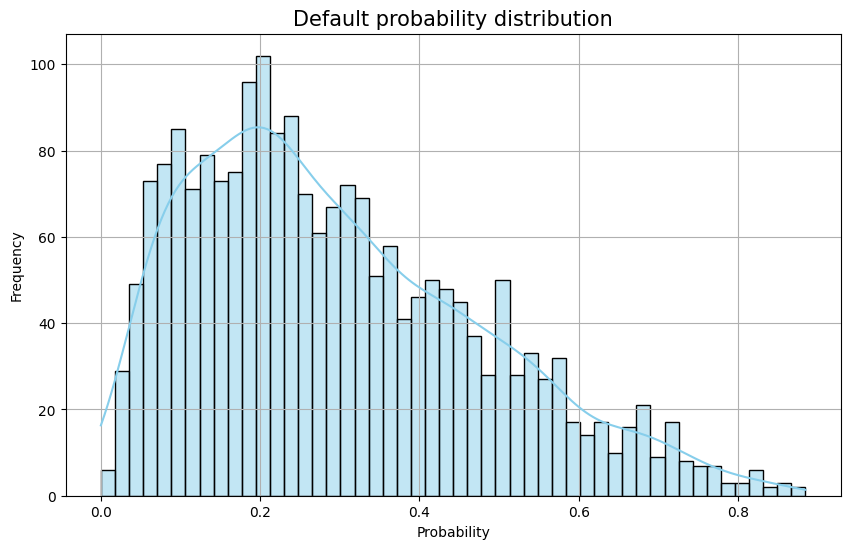

In [11]:
# CSV 파일 불러오기
df = pd.read_csv("submission.csv")

# 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(df["채무 불이행 확률"], bins=50, kde=True, color="skyblue")
plt.title("Default probability distribution", fontsize=15)
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

✅ Test ROC-AUC: 0.6838377737029447


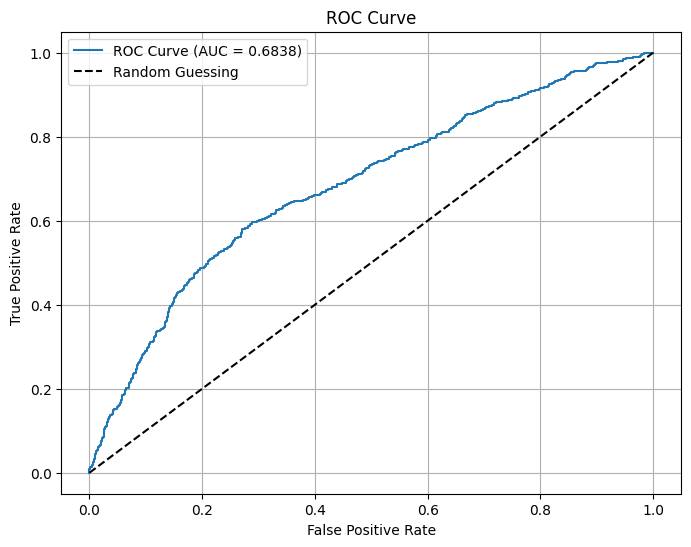

In [12]:
# ✅ ROC-AUC 계산
y_test_proba = sgd_model.predict_proba(X_test)[:, 1]
print("✅ Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))


# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()